In [1]:
# Librerías
# ==============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.eval_measures import rmse
from scipy import stats
from scipy.optimize import curve_fit
from scipy.stats import expon, betaprime, invgamma, lognorm, pareto, gamma
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from typing import Union
import scipy.stats as stats
import keras
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
import tqdm
import inspect
import warnings
warnings.filterwarnings('ignore')

# Analisis Exploratorio de datos

In [2]:
#Definimos la ruta de nuestra base de datos
ruta_archivo_csv = '../bases de datos/df.csv'

# Carga los datos desde el archivo CSV en un DataFrame
datos = pd.read_csv(ruta_archivo_csv, sep=',')
display(datos.info())
datos.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 22 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Unnamed: 0                        8950 non-null   int64  
 1   cust_id                           8950 non-null   object 
 2   activated_date                    8937 non-null   object 
 3   last_payment_date                 8941 non-null   object 
 4   balance                           8948 non-null   float64
 5   balance_frequency                 8950 non-null   float64
 6   purchases                         8950 non-null   float64
 7   oneoff_purchases                  8950 non-null   float64
 8   installments_purchases            8950 non-null   float64
 9   cash_advance                      8838 non-null   float64
 10  purchases_frequency               8950 non-null   float64
 11  oneoff_purchases_frequency        8950 non-null   float64
 12  purcha

None

,Unnamed: 0,cust_id,activated_date,last_payment_date,balance,balance_frequency,purchases,oneoff_purchases,installments_purchases,cash_advance,...,purchases_installments_frequency,cash_advance_frequency,cash_advance_trx,purchases_trx,credit_limit,payments,minimum_payments,prc_full_payment,tenure,fraud
0,1,C10001,2019-10-06,2020-09-09,40.900749,0.818182,95.40,0.00,95.4,0.000000,...,0.083333,0.00,0,2,1000.0,201.802084,139.509787,0.000000,12,0
1,2,C10002,2019-10-06,2020-07-04,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,...,0.000000,0.25,4,0,7000.0,4103.032597,1072.340217,0.222222,12,0
2,3,C10003,2019-10-06,2020-09-17,2495.148862,1.000000,773.17,773.17,0.0,0.000000,...,0.000000,0.00,0,12,7500.0,622.066742,627.284787,0.000000,12,0


In [3]:
datos.tail()

,Unnamed: 0,cust_id,activated_date,last_payment_date,balance,balance_frequency,purchases,oneoff_purchases,installments_purchases,cash_advance,...,purchases_installments_frequency,cash_advance_frequency,cash_advance_trx,purchases_trx,credit_limit,payments,minimum_payments,prc_full_payment,tenure,fraud
8945,8946,C19186,2020-07-31,2020-11-03,28.493517,1.000000,291.12,0.00,291.12,0.000000,...,0.833333,0.000000,0,6,1000.0,325.594462,48.886365,0.50,6,0
8946,8947,C19187,2020-07-31,2020-09-06,19.183215,1.000000,300.00,0.00,300.00,0.000000,...,0.833333,0.000000,0,6,1000.0,275.861322,NaN,0.00,6,0
8947,8948,C19188,2020-07-31,2020-06-03,23.398673,0.833333,144.40,0.00,144.40,0.000000,...,0.666667,0.000000,0,5,1000.0,81.270775,82.418369,0.25,6,0
8948,8949,C19189,2020-07-31,2020-07-19,13.457564,0.833333,0.00,0.00,0.00,36.558778,...,0.000000,0.166667,2,0,500.0,52.549959,55.755628,0.25,6,0
8949,8950,C19190,2020-07-31,2020-10-14,372.708075,0.666667,1093.25,1093.25,0.00,127.040008,...,0.000000,0.333333,2,23,1200.0,63.165404,88.288956,0.00,6,0


# Limpiamos los datos, es decir, quitamos los datos faltantes

In [4]:
# Verificar si hay datos faltantes
datos_faltantes = datos.isnull().sum()

# Mostrar la cantidad de datos faltantes por columna
print(datos_faltantes)

Unnamed: 0                            0
cust_id                               0
activated_date                       13
last_payment_date                     9
balance                               2
balance_frequency                     0
purchases                             0
oneoff_purchases                      0
installments_purchases                0
cash_advance                        112
purchases_frequency                   0
oneoff_purchases_frequency            0
purchases_installments_frequency      0
cash_advance_frequency                0
cash_advance_trx                      0
purchases_trx                         0
credit_limit                          1
payments                              0
minimum_payments                    321
prc_full_payment                      0
tenure                                0
fraud                                 0
dtype: int64


In [5]:
datos_sin_faltantes = datos.dropna()

# Mostrar información del DataFrame después de eliminar los datos faltantes
print(datos_sin_faltantes.info())

<class 'pandas.core.frame.DataFrame'>
Index: 8497 entries, 0 to 8949
Data columns (total 22 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Unnamed: 0                        8497 non-null   int64  
 1   cust_id                           8497 non-null   object 
 2   activated_date                    8497 non-null   object 
 3   last_payment_date                 8497 non-null   object 
 4   balance                           8497 non-null   float64
 5   balance_frequency                 8497 non-null   float64
 6   purchases                         8497 non-null   float64
 7   oneoff_purchases                  8497 non-null   float64
 8   installments_purchases            8497 non-null   float64
 9   cash_advance                      8497 non-null   float64
 10  purchases_frequency               8497 non-null   float64
 11  oneoff_purchases_frequency        8497 non-null   float64
 12  purchases_i

In [6]:
# Reseteamos el índice del DataFrame
datos_sin_faltantes = datos_sin_faltantes.reset_index(drop=True)

# Mostrar información del DataFrame después de eliminar los datos faltantes y resetear el índice
print(datos_sin_faltantes.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8497 entries, 0 to 8496
Data columns (total 22 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Unnamed: 0                        8497 non-null   int64  
 1   cust_id                           8497 non-null   object 
 2   activated_date                    8497 non-null   object 
 3   last_payment_date                 8497 non-null   object 
 4   balance                           8497 non-null   float64
 5   balance_frequency                 8497 non-null   float64
 6   purchases                         8497 non-null   float64
 7   oneoff_purchases                  8497 non-null   float64
 8   installments_purchases            8497 non-null   float64
 9   cash_advance                      8497 non-null   float64
 10  purchases_frequency               8497 non-null   float64
 11  oneoff_purchases_frequency        8497 non-null   float64
 12  purcha

In [7]:
#Vemos si hay clientes repetidos
frecuencia = datos_sin_faltantes['cust_id'].value_counts()
print(frecuencia)

cust_id
C10001    1
C16114    1
C16129    1
C16128    1
C16127    1
         ..
C13078    1
C13077    1
C13076    1
C13074    1
C19190    1
Name: count, Length: 8497, dtype: int64


In [8]:
frecuencia.shape
#como el numero de frecuencia es igual al numero de registro entonces concluimos que no hay clientes repetidos

(8497,)

# Vemos que no haya datos capturados erroneamente, como valores negativos

In [9]:
# Verificar si hay valores negativos en la columna 'columna_datos'
hay_negativos = (datos_sin_faltantes['balance'] < 0).any()

# Imprimir el resultado
if hay_negativos:
    print("La columna contiene valores negativos.")
else:
    print("La columna no contiene valores negativos.")   

La columna no contiene valores negativos.


In [10]:
saldos=datos_sin_faltantes['balance']
# Verificar si hay valores NaN
hay_nan = np.isnan(saldos)
print("¿Hay valores NaN en los datos?", any(hay_nan))

# Verificar si hay valores infinitos
hay_inf = np.isinf(saldos)
print("¿Hay valores infinitos en los datos?", any(hay_inf))

¿Hay valores NaN en los datos? False
¿Hay valores infinitos en los datos? False


# Vemos el saldo máximo y el saldo mínimo que hay en las tarjetas.

In [11]:
saldo_max = max(saldos)
saldo_min =min(saldos)
print('El saldo maximo es: ' + str(saldo_max) + ' y el saldo minimo es: ' + str(saldo_min))

El saldo maximo es: 19043.13856 y el saldo minimo es: 0.0


# Creamos el histograma de saldos

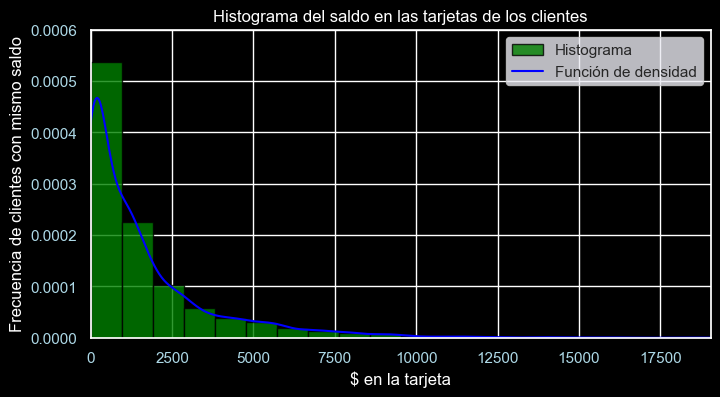

In [37]:
# Configurar el tamaño de la figura
plt.figure(figsize=(8, 4))

# Establecer el estilo de Seaborn con fondo oscuro
sns.set(style='darkgrid')

#Creamos un histograma de densidad de probabilidad
saldos.hist(density=True, bins=20, alpha=0.8, color='green', label='Histograma', edgecolor='black')

# Crear el gráfico de densidad
saldos.plot(kind='kde',color='blue', label='Función de densidad')

# Establecer los límites del eje y, y del eje x
#plt.ylim(0, 0.0006)
plt.xlim(0, saldo_max)


# Agregar etiquetas y título
plt.xlabel('$ en la tarjeta', color='white')
plt.ylabel('Frecuencia de clientes con mismo saldo', color='white')
plt.title('Histograma del saldo en las tarjetas de los clientes', color='white')
plt.legend()

# Configurar el color de fondo de la figura y fuera la figura como negro
plt.gca().set_facecolor('black')
plt.gcf().set_facecolor('black')

# Cambiar el color de los números en los ejes x e y a azul claro
plt.gca().tick_params(axis='x', colors='lightblue')
plt.gca().tick_params(axis='y', colors='lightblue')

# Establecer los límites del eje y, y del eje x
plt.ylim(0, 0.0006)
plt.xlim(0, saldo_max)

# Mostrar el gráfico
plt.show()

Notamos como la distribución del saldo en la tarjeta es asimetrica hacia la derecha, además los saldos son siempre mayores o iguales que 0, por loq ue podriamos calcular cual de las distribuciones con ese dominio se asemeja más a nuestro histograma.

Las funciones de distribución que tienen dominio en el intervalo
∞
)
[0,∞) son conocidas como distribuciones de probabilidad positivas o distribuciones de probabilidad semi-infinitas. Estas distribuciones son útiles trabajamosbajando con variables aleatorias que solo pueden tomar valores no negativos, como duraciones, cantidades o tamaños.

Algunas de las distribuciones de probabilidad más comunes con do[
0
,
∞
)
[01.- ,∞) incluyen:

Distribución exponencial: Modela el tiempo entre eventos en un proc2.- eso de Poisson.

Distribución gamma: Generaliza la distribución exponencial y puede modelar el tiempo hasta el k-ésimo evento en un pr3.- oceso de Poisson.

Distribución Weibull: Utilizada para modelar tiempos de vida o duraciones, y es una generalización de la distri4.- bución exponencial.

Distribución de Pareto: Utilizada para modelar distribuciones de riqueza, tamaños de archivos, i5.- ngresos, entre otros.

Distribución chi-cuadrado: Utilizada en pruebas de hipótesis y en la construcción de i6.- ntervalos de confianza.

Distribución beta: Utilizada para modelar propo7.- rciones y probabilidades.

Distribución log-normal: Utilizada para modelar variables que son el logaritmo de una vari

Aunque podriamos enfocarnos unicamente en la distribución de pareto que mejor se ajusta a nuestro histograma, sin embargo, evaluaremos cual de estas distribuciones es la que mejor se asemeja a nuestros datos.able normalmente distribuida.

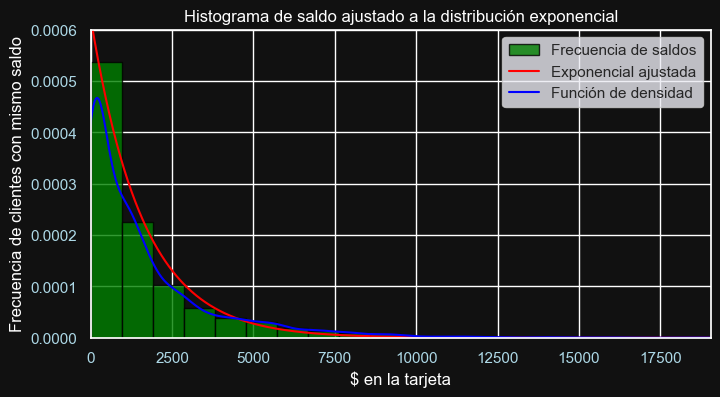

In [13]:
# Eliminar valores no finitos
#datos_limpios = saldos[np.isfinite(saldos)]

# Configurar el tamaño de la figura
plt.figure(figsize=(8, 4))


# Crear histograma
plt.hist(saldos, bins=20, density=True, alpha=0.8, color='green', edgecolor='black', label='Frecuencia de saldos')

# Ajustar distribución exponencial
parametros = expon.fit(saldos)
x = np.linspace(0, 19044, 1000)
pdf = expon.pdf(x, *parametros)

# Graficar distribución exponencial ajustada
plt.plot(x, pdf, color='red', linestyle='-', label='Exponencial ajustada')

saldos.plot(kind='kde',color='blue', label='Función de densidad')

# Establecer los límites del eje y, y del eje x
plt.ylim(0, 0.0006)
plt.xlim(0, saldo_max)

# Agregar etiquetas y título
plt.xlabel('$ en la tarjeta', color='white')
plt.ylabel('Frecuencia de clientes con mismo saldo', color='white')
plt.title('Histograma de saldo ajustado a la distribución exponencial', color='white')
plt.legend()

# Configurar el color de fondo de la figura y fuera la figura como negro
plt.gca().set_facecolor('#111111')
plt.gcf().set_facecolor('#111111')

# Cambiar el color de los números en los ejes x e y a azul claro
plt.gca().tick_params(axis='x', colors='lightblue')
plt.gca().tick_params(axis='y', colors='lightblue')

plt.show()

La distribución ajustada muestra un comortamiento similar a la frecuencia de los saldos, vemos otra distribución como la beta prime, sin embargo para saber cual se ajusta mejor a nuestros datos usaremos el criterio AIC y BIC para las distribuciones mencionadas anteriormente y que nos interezan como: 

1.- Distribución exponencial. 

2.- Distribución gamma. 

3.- Distribución Weibull. 

4.- Distribución de Pareto. 

5.- Distribución chi-cuadrado. 

6.- Distribución beta. 

7.- Distribución log-normal.

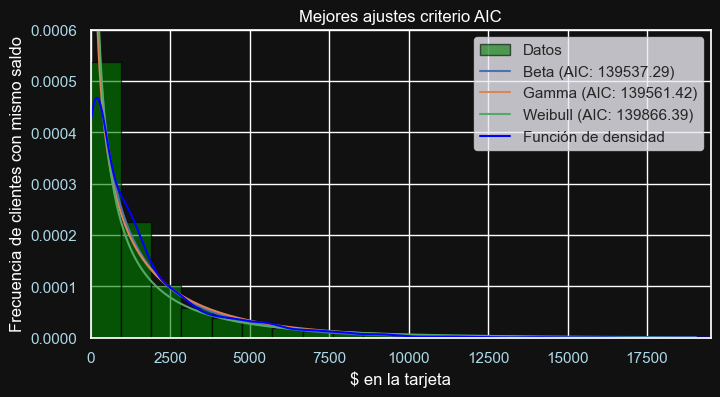

In [14]:
from scipy.stats import expon, gamma, weibull_min, pareto, chi2, beta, lognorm

# Configurar el tamaño de la figura
plt.figure(figsize=(8, 4))

# Crear histograma de los datos
plt.hist(saldos, bins=20, density=True, alpha=0.6, color='green', edgecolor='black', label='Datos')

# Ajustar distribuciones y calcular AIC y BIC
distribuciones = {'Exponencial': expon, 'Gamma': gamma, 'Weibull': weibull_min, 'Pareto': pareto, 'Chi-cuadrado': chi2, 'Beta': beta, 'Log-Normal': lognorm}
resultados = []
for nombre, distribucion in distribuciones.items():
    parametros = distribucion.fit(saldos)
    k = len(parametros)
    ll = distribucion.logpdf(saldos, *parametros)
    aic = -2 * np.sum(ll) + 2 * k
    bic = -2 * np.sum(ll) + k * np.log(len(saldos))
    resultados.append({'Distribución': nombre, 'AIC': aic, 'BIC': bic, 'Parametros': parametros})

# Seleccionar las tres mejores distribuciones según AIC y BIC
resultados_ordenados_por_aic = sorted(resultados, key=lambda x: x['AIC'])
resultados_ordenados_por_bic = sorted(resultados, key=lambda x: x['BIC'])

# Graficar las tres mejores distribuciones según AIC
for resultado in resultados_ordenados_por_aic[:3]:
    distribucion = distribuciones[resultado['Distribución']]
    parametros = resultado['Parametros']
    x = np.linspace(0, 19043, 1000)
    pdf = distribucion.pdf(x, *parametros)
    plt.plot(x, pdf, label=f'{resultado["Distribución"]} (AIC: {resultado["AIC"]:.2f})')


saldos.plot(kind='kde',color='blue', label='Función de densidad')
# Establecer los límites del eje y, y del eje x
plt.ylim(0, 0.0006)
plt.xlim(0, 19500)

# Agregar etiquetas y título
plt.xlabel('$ en la tarjeta', color='white')
plt.ylabel('Frecuencia de clientes con mismo saldo', color='white')
plt.title('Mejores ajustes criterio AIC', color='white')
plt.legend()

# Configurar el color de fondo de la figura y fuera la figura como negro
plt.gca().set_facecolor('#111111')
plt.gcf().set_facecolor('#111111')

# Cambiar el color de los números en los ejes x e y a azul claro
plt.gca().tick_params(axis='x', colors='lightblue')
plt.gca().tick_params(axis='y', colors='lightblue')

plt.show()

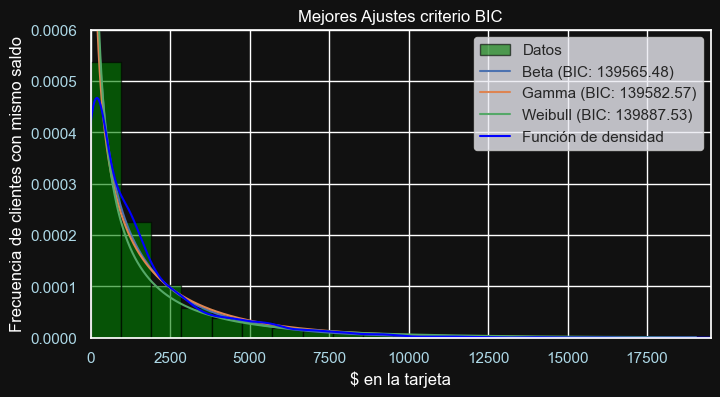

In [15]:
# Configurar el tamaño de la figura
plt.figure(figsize=(8, 4))
# Graficar las tres mejores distribuciones según BIC
plt.hist(saldos, bins=20, density=True, alpha=0.6, color='green', edgecolor='black', label='Datos')
for resultado in resultados_ordenados_por_bic[:3]:
    distribucion = distribuciones[resultado['Distribución']]
    parametros = resultado['Parametros']
    x = np.linspace(0, 19043, 1000)
    pdf = distribucion.pdf(x, *parametros)
    plt.plot(x, pdf, label=f'{resultado["Distribución"]} (BIC: {resultado["BIC"]:.2f})')

saldos.plot(kind='kde',color='blue', label='Función de densidad')
# Establecer los límites del eje y, y del eje x
plt.ylim(0, 0.0006)
plt.xlim(0, 19500)

# Agregar etiquetas y título
plt.xlabel('$ en la tarjeta', color='white')
plt.ylabel('Frecuencia de clientes con mismo saldo', color='white')
plt.title('Mejores Ajustes criterio BIC', color='white')
plt.legend()

# Configurar el color de fondo de la figura y fuera la figura como negro
plt.gca().set_facecolor('#111111')
plt.gcf().set_facecolor('#111111')

# Cambiar el color de los números en los ejes x e y a azul claro
plt.gca().tick_params(axis='x', colors='lightblue')
plt.gca().tick_params(axis='y', colors='lightblue')

plt.show()

# Obtenemos los parámetros de la mejor distribución que obtuvimos anteriormente

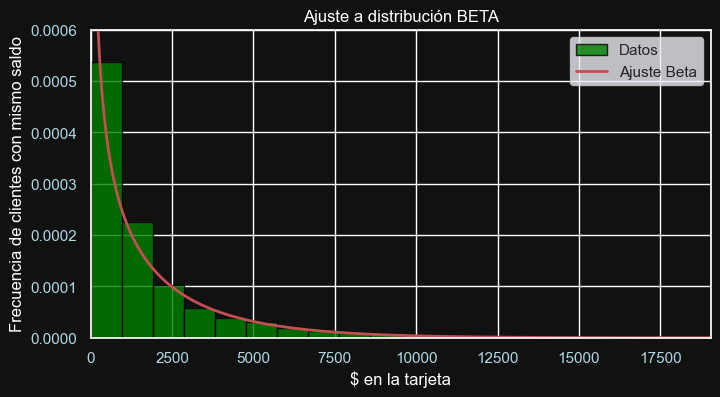

In [16]:
from scipy.optimize import curve_fit

# Configurar el tamaño de la figura
plt.figure(figsize=(8, 4))

# Crear histograma de los datos
plt.hist(saldos, bins=20, density=True, alpha=0.8, color='green', edgecolor='black', label='Datos')

# Ajustar modelo beta
#params_beta = stats.beta.fit(saldos)
#a, b, loc, scale = params_beta

# Ajustar los datos a una distribución beta
parametros = beta.fit(saldos, floc=0)

# Establecer los límites del eje y, y del eje x
plt.ylim(0, 0.0006)
plt.xlim(0, saldo_max)

# Mostrar el ajuste en el histograma
x = np.linspace(0, 19043, 1000)
pdf = beta.pdf(x, *parametros)
plt.plot(x, pdf, 'r-', lw=2, label='Ajuste Beta')

# Agregar etiquetas y título
plt.xlabel('$ en la tarjeta', color='white')
plt.ylabel('Frecuencia de clientes con mismo saldo', color='white')
plt.title('Ajuste a distribución BETA', color='white')
plt.legend()

# Configurar el color de fondo de la figura y fuera la figura como negro
plt.gca().set_facecolor('#111111')
plt.gcf().set_facecolor('#111111')

# Cambiar el color de los números en los ejes x e y a azul claro
plt.gca().tick_params(axis='x', colors='lightblue')
plt.gca().tick_params(axis='y', colors='lightblue')
plt.show()

In [17]:
# Imprimir los parámetros de la distribución beta ajustada
print("Parámetros de la distribución beta ajustada:")
print("alfa:", parametros[0])
print("beta:", parametros[1])
print("loc:", parametros[2])
print("scale:", parametros[3])

Parámetros de la distribución beta ajustada:
alfa: 0.5364416447286349
beta: 13.101323554376021
loc: 0
scale: 40796.70938877843


# Vemos que tan confiable es nuestro ajuste haciendole pruebas de Kolmogorov-Smirnov

In [18]:
from scipy.stats import kstest

# Realizar prueba de Kolmogorov-Smirnov
ks_statistic, ks_p_value = kstest(saldos, 'beta', args=parametros)
print("Estadístico de Kolmogorov-Smirnov:", ks_statistic)
print("Valor p de Kolmogorov-Smirnov:", ks_p_value)

Estadístico de Kolmogorov-Smirnov: 0.03849229871102072
Valor p de Kolmogorov-Smirnov: 2.2456427183976834e-11


In [19]:
from scipy.stats import anderson

# Calcular histograma observado
hist, bin_edges = np.histogram(saldos, bins=30, density=True)

# Calcular histograma esperado de la distribución beta ajustada
pdf_beta = beta.pdf(np.linspace(0, 19043, 30), *parametros)
hist_esperado = pdf_beta * np.diff(bin_edges)

# Normalizar los histogramas observado y esperado
hist = hist / np.sum(hist)
hist_esperado = hist_esperado / np.sum(hist_esperado)

# Calcular el estadístico de Anderson-Darling manualmente
ad_statistic = np.sum((pdf_beta - hist) ** 2 / pdf_beta)
# Calcular los valores críticos de Anderson-Darling
ad_critical_values = [0.325, 1.226, 1.961, 2.718, 3.752]
# Calcular el nivel de significancia de Anderson-Darling
ad_significance_level = [15.0, 10.0, 5.0, 2.5, 1.0]

print("Estadístico de Anderson-Darling:", ad_statistic)
print("Valores críticos de Anderson-Darling:", ad_critical_values)
print("Nivel de significancia de Anderson-Darling:", ad_significance_level)

Estadístico de Anderson-Darling: nan
Valores críticos de Anderson-Darling: [0.325, 1.226, 1.961, 2.718, 3.752]
Nivel de significancia de Anderson-Darling: [15.0, 10.0, 5.0, 2.5, 1.0]


Apesar de que la distribución beta es la que mejor se ajusta a nuestros datos, el valor p ≤ 0.05, por lo tanto Los datos no siguen una distribución beta (Rechazamos H0=de que la distribución no es beta)0)

In [20]:
# Ajustar los datos a una distribución beta
parametros = beta.fit(saldos, floc=0)

# Calcular valores esperados de la distribución beta ajustada
valores_esperados = beta.cdf(saldos, *parametros)

# Calcular el coeficiente de correlación
r = np.corrcoef(saldos, valores_esperados)[0, 1]

# Calcular el coeficiente de determinación (R cuadrado)
r_cuadrado = r**2

print("Coeficiente de correlación (R):", r)
print("Coeficiente de determinación (R cuadrado):", r_cuadrado)

Coeficiente de correlación (R): 0.8108558521911269
Coeficiente de determinación (R cuadrado): 0.6574872130325986


Con esto concluimos que aproximadamente el 65.75% de la variabilidad de los saldos pueden ser explicados por la distribución beta ajustada. En otras palabras, alrededor del 65.75% de la variación en los datos observados puede ser capturada por el modelo de distribución beta ajustado.

# Creamos los datos con el promedio y la mediana de los datos filtrados por mes y año

In [21]:
# Convertir la columna de fechas de activación al formato de fecha
datos_sin_faltantes['activated_date'] = pd.to_datetime(datos_sin_faltantes['activated_date'], format='%Y-%m-%d')

# Extraer el año y el mes de la fecha de activación
datos_sin_faltantes['anio'] = datos_sin_faltantes['activated_date'].dt.year
datos_sin_faltantes['mes'] = datos_sin_faltantes['activated_date'].dt.month

# Agrupar los datos por año y mes y calcular el saldo medio y mediano
informe = datos_sin_faltantes.groupby(['anio', 'mes']).agg({'balance': ['mean', 'median']})

# Renombrar las columnas
informe.columns = ['saldo_medio', 'saldo_mediano']

# Mostrar el informe
print(informe)

          saldo_medio  saldo_mediano
anio mes                            
2019 10   2548.794248    1545.598011
     11   1890.539524    1107.961644
     12   2051.316984    1193.351573
2020 1    1864.259536    1180.961924
     2    1784.641287    1018.880453
     3    1590.094278     894.357857
     4    1540.150147     969.583332
     5    1249.460309     779.431874
     6     971.212562     518.894713
     7     664.835110     251.144969


# Finalmente podemos simular 5 nuevos valores de saldos acorde a la distribución BETA

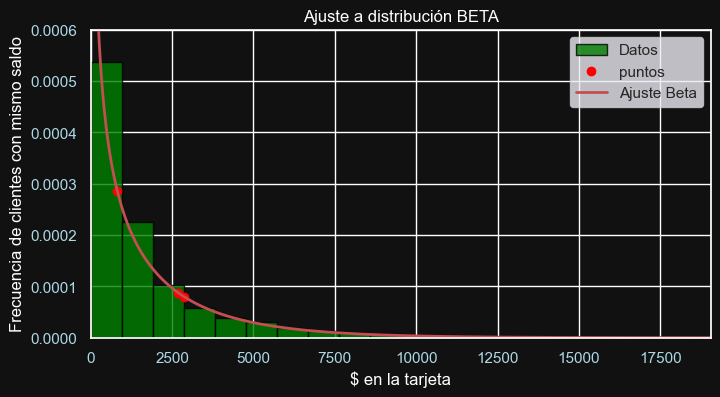

In [22]:
# Configurar el tamaño de la figura
plt.figure(figsize=(8, 4))

# Crear histograma de los datos
plt.hist(saldos, bins=20, density=True, alpha=0.8, color='green', edgecolor='black', label='Datos')

# Ajustar modelo beta
#params_beta = stats.beta.fit(saldos)
#a, b, loc, scale = params_beta

# Ajustar los datos a una distribución beta
#parametros = beta.fit(saldos, floc=0)

# Definición de la distribución
distribucion = stats.beta

# Ajuste para obtener el valor de los parámetros
parametros   = distribucion.fit(saldos.to_numpy())

# Muestreo aleatorio
#distribucion.rvs(*parametros, size=5)

# Establecer los límites del eje y, y del eje x
plt.ylim(0, 0.0006)
plt.xlim(0, saldo_max)


#PREDICCION DE PUNTOS
xp = distribucion.rvs(*parametros, size=5)
pdfp = beta.pdf(xp, *parametros)
plt.plot(xp, pdfp, 'o', lw=2, label='puntos', color='red')

# Mostrar el ajuste en el histograma
x = np.linspace(0, 19043, 1000)
pdf = beta.pdf(x, *parametros)
plt.plot(x, pdf, 'r-', lw=2, label='Ajuste Beta')

# Agregar etiquetas y título
plt.xlabel('$ en la tarjeta', color='white')
plt.ylabel('Frecuencia de clientes con mismo saldo', color='white')
plt.title('Ajuste a distribución BETA', color='white')
plt.legend()

# Configurar el color de fondo de la figura y fuera la figura como negro
plt.gca().set_facecolor('#111111')
plt.gcf().set_facecolor('#111111')

# Cambiar el color de los números en los ejes x e y a azul claro
plt.gca().tick_params(axis='x', colors='lightblue')
plt.gca().tick_params(axis='y', colors='lightblue')
plt.show()

# Ahora crearemos la tabla de los clientes que activaron su cuenta y realizaron su último pago en 2020
Esta tabla contendra el cust_id sin las letras, la fecha activada en formato AAAA-MM, la fecha de último pago en AAAA-MM-DD, el anticipo efectivo, el límite de credito y el cash_adv como % del limite de credito

In [23]:
display(datos_sin_faltantes.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8497 entries, 0 to 8496
Data columns (total 24 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   Unnamed: 0                        8497 non-null   int64         
 1   cust_id                           8497 non-null   object        
 2   activated_date                    8497 non-null   datetime64[ns]
 3   last_payment_date                 8497 non-null   object        
 4   balance                           8497 non-null   float64       
 5   balance_frequency                 8497 non-null   float64       
 6   purchases                         8497 non-null   float64       
 7   oneoff_purchases                  8497 non-null   float64       
 8   installments_purchases            8497 non-null   float64       
 9   cash_advance                      8497 non-null   float64       
 10  purchases_frequency               8497 non-null 

None

In [24]:
# Crear una copia del DataFrame original para evitar cambios accidentales
df_copy = datos_sin_faltantes.copy()

# Eliminar el carácter 'C' de la columna 'cust_id'
df_copy['cust_id'] = df_copy['cust_id'].str.replace('C', '')

# Verificar los primeros registros del DataFrame modificado
df_copy.head()

,Unnamed: 0,cust_id,activated_date,last_payment_date,balance,balance_frequency,purchases,oneoff_purchases,installments_purchases,cash_advance,...,cash_advance_trx,purchases_trx,credit_limit,payments,minimum_payments,prc_full_payment,tenure,fraud,anio,mes
0,1,10001,2019-10-06,2020-09-09,40.900749,0.818182,95.40,0.00,95.40,0.000000,...,0,2,1000.0,201.802084,139.509787,0.000000,12,0,2019,10
1,2,10002,2019-10-06,2020-07-04,3202.467416,0.909091,0.00,0.00,0.00,6442.945483,...,4,0,7000.0,4103.032597,1072.340217,0.222222,12,0,2019,10
2,3,10003,2019-10-06,2020-09-17,2495.148862,1.000000,773.17,773.17,0.00,0.000000,...,0,12,7500.0,622.066742,627.284787,0.000000,12,0,2019,10
3,5,10005,2019-10-06,2020-10-20,817.714335,1.000000,16.00,16.00,0.00,0.000000,...,0,1,1200.0,678.334763,244.791237,0.000000,12,0,2019,10
4,6,10006,2019-10-06,2020-07-27,1809.828751,1.000000,1333.28,0.00,1333.28,0.000000,...,0,8,1800.0,1400.057770,2407.246035,0.000000,12,0,2019,10


In [25]:
df_copy.shape

(8497, 24)

In [26]:
#filtramos las fechas de los clientes que activaron su cuenta en el año 2020 y realizaron su ultimo pago en ese mismo año 

# Convertirmos la columna 'fecha' a tipo datetime
df_copy['activated_date'] = pd.to_datetime(df_copy['activated_date'])

# Filtrar las fechas para el año 2020
anio = '2020'
df_copy = df_copy.loc[df_copy['activated_date'].dt.strftime('%Y').str.startswith(anio)]

# Eliminar el componente del día (DD) de las fechas
df_copy['activated_date'] = df_copy['activated_date'].dt.strftime('%Y-%m')

# Mostrar el DataFrame filtrado
df_copy.head()

,Unnamed: 0,cust_id,activated_date,last_payment_date,balance,balance_frequency,purchases,oneoff_purchases,installments_purchases,cash_advance,...,cash_advance_trx,purchases_trx,credit_limit,payments,minimum_payments,prc_full_payment,tenure,fraud,anio,mes
2481,2634,12709,2020-01,2020-05-08,2917.656276,1.0,141.81,141.81,0.00,2431.292076,...,10,2,8000.0,993.289914,1013.060637,0.0,12,0,2020,1
2482,2635,12710,2020-01,2020-05-26,542.807485,1.0,220.62,220.62,0.00,0.000000,...,0,3,2000.0,608.782428,166.733071,0.0,12,0,2020,1
2483,2636,12712,2020-01,2020-10-20,2362.643772,1.0,2826.99,1496.59,1330.40,0.000000,...,0,97,3000.0,1748.687628,984.331832,0.0,12,0,2020,1
2484,2637,12713,2020-01,2020-08-22,4164.796859,1.0,784.63,617.54,167.09,0.000000,...,0,16,9000.0,1072.433416,1311.061985,0.0,11,0,2020,1
2485,2638,12714,2020-01,2020-04-26,1304.460033,1.0,0.00,0.00,0.00,78.763096,...,2,0,1500.0,395.136073,368.588193,0.0,12,0,2020,1


In [27]:
df_copy.shape

(6016, 24)

In [28]:
# Lista de columnas a conservar
#se agraga 'fraud' y 'balance' para el modelo que se creará más adelante 
columnas_a_conservar = ['cust_id', 'activated_date', 'last_payment_date', 'cash_advance', 'credit_limit','fraud','balance']

# Eliminar las columnas no deseadas y conservar las deseadas
df_filtrado = df_copy.drop(columns=df_copy.columns.difference(columnas_a_conservar))

#agregar una nueva columna con el anticipo de efectivo como % del limite de credito
# Calcular el porcentaje y agregarlo como una nueva columna
df_filtrado['% del limite cubierto'] = (df_filtrado['cash_advance'] / df_filtrado['credit_limit']) * 100

# Mostrar el DataFrame filtrado
df_filtrado.head()

,cust_id,activated_date,last_payment_date,balance,cash_advance,credit_limit,fraud,% del limite cubierto
2481,12709,2020-01,2020-05-08,2917.656276,2431.292076,8000.0,0,30.391151
2482,12710,2020-01,2020-05-26,542.807485,0.000000,2000.0,0,0.000000
2483,12712,2020-01,2020-10-20,2362.643772,0.000000,3000.0,0,0.000000
2484,12713,2020-01,2020-08-22,4164.796859,0.000000,9000.0,0,0.000000
2485,12714,2020-01,2020-04-26,1304.460033,78.763096,1500.0,0,5.250873


# Creación del modelo que nos ayude a identificar proximos fraudes sobre clientes 
en este caso se hará con una red neuronal, para ello comenzaremos viendo si el numero de fraudes ocurridos en 2020 es igual al numero de fraudes de 2019+2020

In [29]:
#Vemos el numero de fraudes ocurridos tanto en 2019 y 2020 y los ocurridos en 2020
frecuencia1 = datos_sin_faltantes['fraud'].value_counts()
frecuencia2 = df_filtrado['fraud'].value_counts()
print(frecuencia1,frecuencia2)

fraud
0    8429
1      68
Name: count, dtype: int64 fraud
0    5990
1      26
Name: count, dtype: int64


Como el numero de fraudes es mayor contando los datos de 2019, se usaran todos los datos

In [30]:
print(datos_sin_faltantes.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8497 entries, 0 to 8496
Data columns (total 24 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   Unnamed: 0                        8497 non-null   int64         
 1   cust_id                           8497 non-null   object        
 2   activated_date                    8497 non-null   datetime64[ns]
 3   last_payment_date                 8497 non-null   object        
 4   balance                           8497 non-null   float64       
 5   balance_frequency                 8497 non-null   float64       
 6   purchases                         8497 non-null   float64       
 7   oneoff_purchases                  8497 non-null   float64       
 8   installments_purchases            8497 non-null   float64       
 9   cash_advance                      8497 non-null   float64       
 10  purchases_frequency               8497 non-null 

quitaremos algunas columnas que no incluiremos en nuestro modelo como cust_id, activated_date,  last_payment_dat, ya que la columna 'tenure' nos indica el numero de meses con la tarjeta 

In [31]:
# Creamos una lista con los nombres de las columnas que queremos eliminar
columnas_a_eliminar = ['cust_id','activated_date','last_payment_date', 'fraud', 'anio','mes']

# Utilizamos el método drop para eliminar esas columnas y creamos una copia del DataFrame
train = datos_sin_faltantes.drop(columnas_a_eliminar, axis=1).copy()
labels = datos_sin_faltantes['fraud'].copy()

#convertimos los arrays a tipo pandas
train = pd.DataFrame(train)
labels = pd.DataFrame(labels)
onehot = to_categorical(labels,num_classes=len(np.unique(labels)))

train.head(10)

,Unnamed: 0,balance,balance_frequency,purchases,oneoff_purchases,installments_purchases,cash_advance,purchases_frequency,oneoff_purchases_frequency,purchases_installments_frequency,cash_advance_frequency,cash_advance_trx,purchases_trx,credit_limit,payments,minimum_payments,prc_full_payment,tenure
0,1,40.900749,0.818182,95.40,0.00,95.40,0.000000,0.166667,0.000000,0.083333,0.00,0,2,1000.0,201.802084,139.509787,0.000000,12
1,2,3202.467416,0.909091,0.00,0.00,0.00,6442.945483,0.000000,0.000000,0.000000,0.25,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,3,2495.148862,1.000000,773.17,773.17,0.00,0.000000,1.000000,1.000000,0.000000,0.00,0,12,7500.0,622.066742,627.284787,0.000000,12
3,5,817.714335,1.000000,16.00,16.00,0.00,0.000000,0.083333,0.083333,0.000000,0.00,0,1,1200.0,678.334763,244.791237,0.000000,12
4,6,1809.828751,1.000000,1333.28,0.00,1333.28,0.000000,0.666667,0.000000,0.583333,0.00,0,8,1800.0,1400.057770,2407.246035,0.000000,12
5,7,627.260806,1.000000,7091.01,6402.63,688.38,0.000000,1.000000,1.000000,1.000000,0.00,0,64,13500.0,6354.314328,198.065894,1.000000,12
6,8,1823.652743,1.000000,436.20,0.00,436.20,0.000000,1.000000,0.000000,1.000000,0.00,0,12,2300.0,679.065082,532.033990,0.000000,12
7,10,152.225975,0.545455,1281.60,1281.60,0.00,0.000000,0.166667,0.166667,0.000000,0.00,0,3,11000.0,1164.770591,100.302262,0.000000,12
8,11,1293.124939,1.000000,920.12,0.00,920.12,0.000000,1.000000,0.000000,1.000000,0.00,0,12,1200.0,1083.301007,2172.697765,0.000000,12
9,12,630.794744,0.818182,1492.18,1492.18,0.00,0.000000,0.250000,0.250000,0.000000,0.00,0,6,2000.0,705.618627,155.549069,0.000000,12


In [32]:
#Dividir datos de entrenamiento
np.random.seed(100)
indices = np.random.permutation(train.shape[0])
valid_cnt = int(train.shape[0]*0.1)
test_idx, training_idx = indices[:valid_cnt],\
                    indices[valid_cnt:]
test,train = train.iloc[test_idx,:],\
                    train.iloc[training_idx]
onehot_test, onehot_train = onehot[test_idx,:],\
                onehot[training_idx,:]

In [33]:
#Definimos la arquitectura de la Red Neuronal
from keras.models import Sequential, save_model, load_model
from keras.layers import Dense, Dropout

model=Sequential()
input_size =  18
output_size = 2

model.add(Dense(32,input_dim=input_size,activation='relu'))
model.add(Dense(2,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(output_size,activation='softmax'))

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                608       
                                                                 
 dense_1 (Dense)             (None, 2)                 66        
                                                                 
 dropout (Dropout)           (None, 2)                 0         
                                                                 
 dense_2 (Dense)             (None, 2)                 6         
                                                                 
Total params: 680 (2.66 KB)
Trainable params: 680 (2.66 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [34]:
#definimos opciones del optimizador
from keras.optimizers import SGD
model.compile(loss='categorical_crossentropy',optimizer=SGD(learning_rate=0.01,weight_decay=1e-6,momentum=0.9,nesterov=True),metrics=['accuracy'])

In [35]:
history=model.fit(train,onehot_train,
                 epochs=10,
                 batch_size=500,
                 validation_data=(test,onehot_test),
                 verbose=1)

Epoch 1/10


16/16 [==============================] - 4s 46ms/step - loss: 0.6023 - accuracy: 0.9918 - val_loss: 0.3758 - val_accuracy: 0.9929
Epoch 2/10
16/16 [==============================] - 0s 11ms/step - loss: 0.2747 - accuracy: 0.9919 - val_loss: 0.1857 - val_accuracy: 0.9929
Epoch 3/10
16/16 [==============================] - 0s 10ms/step - loss: 0.1536 - accuracy: 0.9919 - val_loss: 0.1217 - val_accuracy: 0.9929
Epoch 4/10
16/16 [==============================] - 0s 10ms/step - loss: 0.1108 - accuracy: 0.9919 - val_loss: 0.0955 - val_accuracy: 0.9929
Epoch 5/10
16/16 [==============================] - 0s 9ms/step - loss: 0.0914 - accuracy: 0.9919 - val_loss: 0.0818 - val_accuracy: 0.9929
Epoch 6/10
16/16 [==============================] - 0s 11ms/step - loss: 0.0806 - accuracy: 0.9919 - val_loss: 0.0732 - val_accuracy: 0.9929
Epoch 7/10
16/16 [==============================] - 0s 12ms/step - loss: 0.0736 - accuracy: 0.9919 - val_loss: 0.0675 - val_accuracy: 0.9929
Epoch 8/10
1

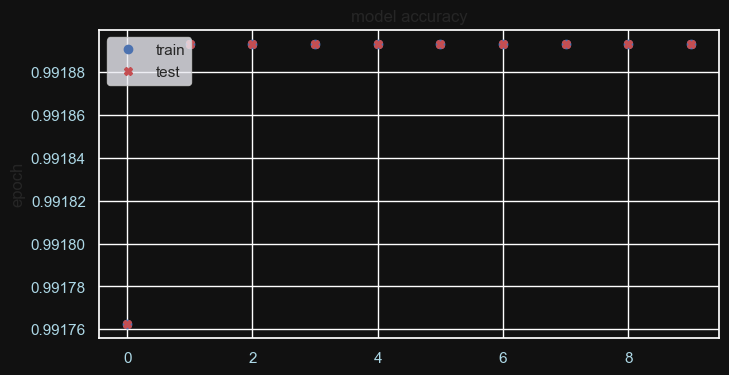

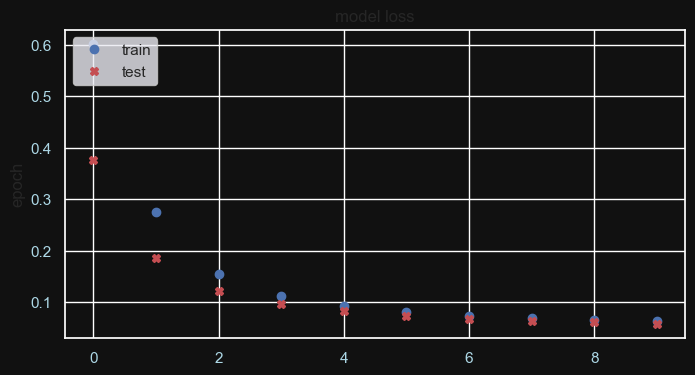

In [36]:
# Configurar el tamaño de la figura
plt.figure(figsize=(8, 4))
plt.plot(history.history['accuracy'],'bo')
plt.plot(history.history['accuracy'],'rX')
plt.title('model accuracy')
plt.ylabel('accuracy',  color='white')
plt.ylabel('epoch',  color='white')
plt.legend(['train','test'], loc='upper left')

# Configurar el color de fondo de la figura y fuera la figura como negro
plt.gca().set_facecolor('#111111')
plt.gcf().set_facecolor('#111111')

# Cambiar el color de los números en los ejes x e y a azul claro
plt.gca().tick_params(axis='x', colors='lightblue')
plt.gca().tick_params(axis='y', colors='lightblue')

plt.show()

# Configurar el tamaño de la figura
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'],'bo')
plt.plot(history.history['val_loss'],'rX')
plt.title('model loss',)
plt.ylabel('loss')
plt.ylabel('epoch')
plt.legend(['train','test'], loc='upper left')

# Configurar el color de fondo de la figura y fuera la figura como negro
plt.gca().set_facecolor('#111111')
plt.gcf().set_facecolor('#111111')

# Cambiar el color de los números en los ejes x e y a azul claro
plt.gca().tick_params(axis='x', colors='lightblue')
plt.gca().tick_params(axis='y', colors='lightblue')

plt.show()

In [ ]:
#Falta ver el over fiting de esta red